# FNN for forecast

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

## load data

In [51]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## normalization

In [52]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [53]:
def Series_To_Supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + target_len, -1]
    print("Supervised Data: Shape of x: {}, Shape of y: {}".format(x.shape, y.shape))
    return x, y

## feature seletion

In [54]:
def select_feature(X, Y, feature_num=100):
    """
    X: features
    Y: labels
    feature_num: num of selected features
    return: index of selected features
    """
    X = X.reshape(X.shape[0], -1)
    model = XGBRegressor()
    model.fit(X, Y)
    model.importance_type = 'weight'
    ind = (-model.feature_importances_).argsort()[0:feature_num]
    return ind

## 5-folds TimeSeriesSplit

In [55]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## model define

In [1]:
class FNN(nn.Module):
    """
    A fnn neural network
    """
    def __init__(self, input_size, output_size, hidden_dim, drop_prob):
        super(FNN, self).__init__()
        
        self.fnn = nn.Sequential(
            nn.Linear(input_size, 500),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(250, hidden_dim),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_dim,output_size)
        )
    
    def forward(self, x):
        out = self.fnn(x)
        return out

NameError: name 'nn' is not defined

## model training for  hyper-parameters optimization

In [57]:
def train_model_hpo(train_x_list, train_y_list, valid_x_list, valid_y_list,
                    input_size, output_size, mse_thresh, batch_size, lr,
                    number_epoch, hidden_dim, drop_prob, weight_decay):
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model_fnn = FNN(input_size, output_size, hidden_dim, drop_prob)
            model_fnn.to(device=device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model_fnn.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        step_size=1,
                                                        gamma=0.98)
            valid_loss_min = np.Inf
            print('cross-validation dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))
            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            num_without_imp = 0
            # training process
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True)
                for i, (inputs, labels) in loop:
                    inputs = inputs.to(device=device)
                    labels = labels.to(device=device)
                    optimizer.zero_grad()
                    outputs = model_fnn(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    if i % 5 == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model_fnn.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            out = model_fnn(inp)
                            valid_loss = criterion(out, lab)
                            valid_losses.append(valid_loss.item())

                        model_fnn.train()
                        loop.set_description("Epoch: {}/{}".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                scheduler.step()
                if num_without_imp >= 80:
                    break
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [58]:
seq_len = 72
target_len = 24
feature_num = 100
mse_thresh = 0.01


def model_config():
    batch_sizes = [512, 256, 128]
    lrs = [0.001, 0.005, 0.01]
    number_epochs = [50]
    hidden_dims = [120, 100, 150, 80]
    drop_probs = [0.1]
    weight_decays = [1e-9]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in hidden_dims:
                    for m in drop_probs:
                        for n in weight_decays:
                            configs.append({
                                'batch_size': i,
                                'lr': j,
                                'number_epoch': k,
                                'hidden_dim': l,
                                'drop_prob': m,
                                'weight_decay': n
                            })
    return configs

## random search for HPO

In [59]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  feature_num=feature_num,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.7 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = Series_To_Supervise(train_data, seq_len, target_len)
    #     ind = select_feature(train_x, train_y, feature_num=feature_num)
    train_x = train_x.reshape(train_x.shape[0], -1)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
#     with enough data
#     train_x_list = train_x_list[-1:]
#     train_y_list = train_y_list[-1:]
#     valid_x_list = valid_x_list[-1:]
#     valid_y_list = valid_y_list[-1:]
    
    configs = model_config()
    records = []
    input_size = train_x.shape[1]
    output_size = target_len
    for i in range(30):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        hidden_dim = config['hidden_dim']
        drop_prob = config['drop_prob']
        weight_decay = config['weight_decay']
        print(
            "model config: batch_size--{}, lr--{}, number_epoch--{}, hidden_dim--{},drop_prob-{},weight_decay-{}"
            .format(batch_size, lr, number_epoch, hidden_dim, drop_prob, weight_decay))
        valid_loss = train_model_hpo(train_x_list, train_y_list, valid_x_list,
                                     valid_y_list, input_size, output_size,
                                     mse_thresh, batch_size, lr, number_epoch,
                                     hidden_dim, drop_prob, weight_decay)
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'hidden_dim': hidden_dim,
            'drop_prob': drop_prob,
            'weight_decay': weight_decay,
            'valid_loss': valid_loss
        })
    return records

## run random search

In [ ]:
records = run_model_hpo()

Supervised Data: Shape of x: (22066, 72, 16), Shape of y: (22066, 24)
model config: batch_size--128, lr--0.001, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 24/50: 100%|██████████| 29/29 [00:00<00:00, 52.89it/s, train_loss=0.00134, valid_loss=0.0111]


cross-validation dataset 1


Epoch: 24/50: 100%|██████████| 58/58 [00:01<00:00, 50.47it/s, train_loss=0.00679, valid_loss=0.0134]


cross-validation dataset 1


Epoch: 19/50: 100%|██████████| 58/58 [00:01<00:00, 49.06it/s, train_loss=0.00203, valid_loss=0.00671]


cross-validation dataset 2


Epoch: 9/50: 100%|██████████| 87/87 [00:02<00:00, 42.02it/s, train_loss=0.00256, valid_loss=0.0085] 


cross-validation dataset 3


Epoch: 9/50: 100%|██████████| 115/115 [00:02<00:00, 51.12it/s, train_loss=0.00242, valid_loss=0.00269]


cross-validation dataset 4


Epoch: 16/50: 100%|██████████| 144/144 [00:02<00:00, 51.73it/s, train_loss=0.00211, valid_loss=0.00189]


model config: batch_size--256, lr--0.01, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 44/50: 100%|██████████| 15/15 [00:00<00:00, 63.41it/s, train_loss=0.0102, valid_loss=0.0233]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 64.11it/s, train_loss=0.00787, valid_loss=0.0161]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 63.53it/s, train_loss=0.00825, valid_loss=0.0168]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 52.67it/s, train_loss=0.00734, valid_loss=0.021]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 51.17it/s, train_loss=0.015, valid_loss=0.0258]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 51.83it/s, train_loss=0.0151, valid_loss=0.0307]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 55.86it/s, train_loss=0.00408, valid_loss=0.00887]


cross-validation dataset 1


Epoch: 45/50: 100%|██████████| 29/29 [00:00<00:00, 57.55it/s, train_loss=0.0208, valid_loss=0.0294]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 55.40it/s, train_loss=0.00579, valid_loss=0.00802]


cross-validation dataset 2


Epoch: 25/50: 100%|██████████| 44/44 [00:00<00:00, 57.83it/s, train_loss=0.00785, valid_loss=0.00789]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 58/58 [00:00<00:00, 97.99it/s, train_loss=0.0209, valid_loss=0.0233] 


cross-validation dataset 3


Epoch: 20/50: 100%|██████████| 58/58 [00:00<00:00, 84.85it/s, train_loss=0.0185, valid_loss=0.023]  


cross-validation dataset 3


Epoch: 24/50: 100%|██████████| 58/58 [00:00<00:00, 97.71it/s, train_loss=0.0116, valid_loss=0.0138] 


cross-validation dataset 4


Epoch: 21/50: 100%|██████████| 72/72 [00:00<00:00, 85.11it/s, train_loss=0.00481, valid_loss=0.0034] 


model config: batch_size--256, lr--0.001, number_epoch--50, hidden_dim--120,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 39/50: 100%|██████████| 15/15 [00:00<00:00, 100.80it/s, train_loss=0.00128, valid_loss=0.0187]


cross-validation dataset 1


Epoch: 47/50: 100%|██████████| 29/29 [00:00<00:00, 96.37it/s, train_loss=0.00122, valid_loss=0.00512]


cross-validation dataset 2


Epoch: 25/50: 100%|██████████| 44/44 [00:00<00:00, 87.79it/s, train_loss=0.00205, valid_loss=0.00658]


cross-validation dataset 3


Epoch: 20/50: 100%|██████████| 58/58 [00:00<00:00, 87.79it/s, train_loss=0.00225, valid_loss=0.00166]


cross-validation dataset 4


Epoch: 16/50: 100%|██████████| 72/72 [00:00<00:00, 93.08it/s, train_loss=0.00185, valid_loss=0.00194]


model config: batch_size--256, lr--0.005, number_epoch--50, hidden_dim--80,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 100.00it/s, train_loss=0.0082, valid_loss=0.0152]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 99.78it/s, train_loss=0.00254, valid_loss=0.00857]


cross-validation dataset 1


Epoch: 35/50: 100%|██████████| 29/29 [00:00<00:00, 88.59it/s, train_loss=0.00371, valid_loss=0.00849]


cross-validation dataset 2


Epoch: 22/50: 100%|██████████| 44/44 [00:00<00:00, 98.91it/s, train_loss=0.00409, valid_loss=0.0076] 


cross-validation dataset 3


Epoch: 29/50: 100%|██████████| 58/58 [00:00<00:00, 98.24it/s, train_loss=0.00434, valid_loss=0.00494]


cross-validation dataset 4


Epoch: 24/50: 100%|██████████| 72/72 [00:00<00:00, 97.87it/s, train_loss=0.00314, valid_loss=0.00243] 


model config: batch_size--512, lr--0.005, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.88it/s, train_loss=0.0126, valid_loss=0.0223]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.24it/s, train_loss=0.00389, valid_loss=0.0104]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 97.37it/s, train_loss=0.00511, valid_loss=0.00858]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 81.62it/s, train_loss=0.00374, valid_loss=0.00692]


cross-validation dataset 3


Epoch: 45/50: 100%|██████████| 29/29 [00:00<00:00, 94.90it/s, train_loss=0.0038, valid_loss=0.00287] 


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 91.31it/s, train_loss=0.00286, valid_loss=0.00222]


model config: batch_size--512, lr--0.001, number_epoch--50, hidden_dim--80,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.22it/s, train_loss=0.00191, valid_loss=0.0114]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 96.77it/s, train_loss=0.00212, valid_loss=0.00249]


cross-validation dataset 2


Epoch: 24/50: 100%|██████████| 22/22 [00:00<00:00, 59.40it/s, train_loss=0.00248, valid_loss=0.00938]


cross-validation dataset 3


Epoch: 40/50: 100%|██████████| 29/29 [00:00<00:00, 83.85it/s, train_loss=0.0019, valid_loss=0.00156] 


cross-validation dataset 4


Epoch: 27/50: 100%|██████████| 36/36 [00:00<00:00, 77.36it/s, train_loss=0.00215, valid_loss=0.002]  


model config: batch_size--512, lr--0.005, number_epoch--50, hidden_dim--80,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.90it/s, train_loss=0.0126, valid_loss=0.0229]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.19it/s, train_loss=0.00857, valid_loss=0.0421]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.68it/s, train_loss=0.00453, valid_loss=0.0109]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 69.57it/s, train_loss=0.0123, valid_loss=0.0216]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.00it/s, train_loss=0.00561, valid_loss=0.0209]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.01it/s, train_loss=0.00327, valid_loss=0.0117]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.11it/s, train_loss=0.00852, valid_loss=0.0152]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.70it/s, train_loss=0.0035, valid_loss=0.00926]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 83.92it/s, train_loss=0.00489, valid_loss=0.00589]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 52.46it/s, train_loss=0.00363, valid_loss=0.00651]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 69.92it/s, train_loss=0.00327, valid_loss=0.00343]


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:01<00:00, 32.76it/s, train_loss=0.0162, valid_loss=0.0161]


cross-validation dataset 4


Epoch: 47/50: 100%|██████████| 36/36 [00:00<00:00, 43.01it/s, train_loss=0.00423, valid_loss=0.00295]


model config: batch_size--256, lr--0.001, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 42/50: 100%|██████████| 15/15 [00:00<00:00, 32.07it/s, train_loss=0.00125, valid_loss=0.017]


cross-validation dataset 1


Epoch: 30/50: 100%|██████████| 29/29 [00:00<00:00, 34.37it/s, train_loss=0.00194, valid_loss=0.00334]


cross-validation dataset 2


Epoch: 14/50: 100%|██████████| 44/44 [00:01<00:00, 40.46it/s, train_loss=0.00236, valid_loss=0.0065] 


cross-validation dataset 3


Epoch: 21/50: 100%|██████████| 58/58 [00:01<00:00, 34.04it/s, train_loss=0.00202, valid_loss=0.00173]


cross-validation dataset 4


Epoch: 23/50: 100%|██████████| 72/72 [00:02<00:00, 35.09it/s, train_loss=0.00203, valid_loss=0.00175]


model config: batch_size--128, lr--0.01, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:01<00:00, 28.61it/s, train_loss=0.0131, valid_loss=0.0222]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 32.38it/s, train_loss=0.00334, valid_loss=0.0131]


cross-validation dataset 0


Epoch: 37/50: 100%|██████████| 29/29 [00:00<00:00, 29.46it/s, train_loss=0.0103, valid_loss=0.0237] 


cross-validation dataset 0


Epoch: 27/50: 100%|██████████| 29/29 [00:01<00:00, 28.26it/s, train_loss=0.00943, valid_loss=0.0225]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 35.85it/s, train_loss=0.00505, valid_loss=0.0106]


cross-validation dataset 1


Epoch: 17/50: 100%|██████████| 58/58 [00:01<00:00, 30.38it/s, train_loss=0.00603, valid_loss=0.0117] 


cross-validation dataset 2


Epoch: 19/50: 100%|██████████| 87/87 [00:03<00:00, 28.71it/s, train_loss=0.00566, valid_loss=0.0101] 


cross-validation dataset 3


Epoch: 12/50: 100%|██████████| 115/115 [00:04<00:00, 27.67it/s, train_loss=0.0256, valid_loss=0.0351]


cross-validation dataset 3


Epoch: 25/50: 100%|██████████| 115/115 [00:03<00:00, 29.67it/s, train_loss=0.0175, valid_loss=0.0168]


cross-validation dataset 3


Epoch: 10/50: 100%|██████████| 115/115 [00:03<00:00, 30.44it/s, train_loss=0.0141, valid_loss=0.014] 


cross-validation dataset 3


Epoch: 17/50: 100%|██████████| 115/115 [00:03<00:00, 33.13it/s, train_loss=0.00756, valid_loss=0.00607]


cross-validation dataset 4


Epoch: 18/50: 100%|██████████| 144/144 [00:04<00:00, 30.85it/s, train_loss=0.0191, valid_loss=0.0206]


cross-validation dataset 4


Epoch: 15/50: 100%|██████████| 144/144 [00:04<00:00, 34.23it/s, train_loss=0.00467, valid_loss=0.0057] 


model config: batch_size--512, lr--0.001, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.80it/s, train_loss=0.00143, valid_loss=0.0139]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 34.83it/s, train_loss=0.00149, valid_loss=0.00424]


cross-validation dataset 2


Epoch: 27/50: 100%|██████████| 22/22 [00:00<00:00, 39.79it/s, train_loss=0.00269, valid_loss=0.00915]


cross-validation dataset 3


Epoch: 34/50: 100%|██████████| 29/29 [00:00<00:00, 40.97it/s, train_loss=0.00182, valid_loss=0.00174]


cross-validation dataset 4


Epoch: 43/50: 100%|██████████| 36/36 [00:00<00:00, 42.27it/s, train_loss=0.00137, valid_loss=0.00151]


model config: batch_size--512, lr--0.01, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 30.49it/s, train_loss=0.0313, valid_loss=0.0497]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 33.10it/s, train_loss=0.0109, valid_loss=0.023]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.78it/s, train_loss=0.00854, valid_loss=0.0216]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s, train_loss=0.0569, valid_loss=0.0876]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.40it/s, train_loss=0.0441, valid_loss=0.0656]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 23.13it/s, train_loss=0.0201, valid_loss=0.0398]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.15it/s, train_loss=0.0147, valid_loss=0.0307]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 33.92it/s, train_loss=0.00959, valid_loss=0.0238]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.01it/s, train_loss=0.0134, valid_loss=0.0275]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 49.11it/s, train_loss=0.0166, valid_loss=0.0317]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.51it/s, train_loss=0.00771, valid_loss=0.0199]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 44.95it/s, train_loss=0.0141, valid_loss=0.039]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 56.87it/s, train_loss=0.0199, valid_loss=0.0358]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.87it/s, train_loss=0.0236, valid_loss=0.0393]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 30.62it/s, train_loss=0.0109, valid_loss=0.0192]


cross-validation dataset 0


Epoch: 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.74it/s, train_loss=0.0177, valid_loss=0.054]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.64it/s, train_loss=0.00861, valid_loss=0.0262]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.17it/s, train_loss=0.00947, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s, train_loss=0.013, valid_loss=0.0294] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 29.46it/s, train_loss=0.0164, valid_loss=0.0289]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 29.18it/s, train_loss=0.00697, valid_loss=0.0184]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 31.23it/s, train_loss=0.0186, valid_loss=0.0332]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.30it/s, train_loss=0.0166, valid_loss=0.0327]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.26it/s, train_loss=0.0135, valid_loss=0.024] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.44it/s, train_loss=0.031, valid_loss=0.0454]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.23it/s, train_loss=0.0145, valid_loss=0.038] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s, train_loss=0.0169, valid_loss=0.0351]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.04it/s, train_loss=0.0108, valid_loss=0.0256]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.69it/s, train_loss=0.00804, valid_loss=0.0191]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 46.31it/s, train_loss=0.00906, valid_loss=0.0225]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 77.36it/s, train_loss=0.00986, valid_loss=0.0245]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.76it/s, train_loss=0.0228, valid_loss=0.0393]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.46it/s, train_loss=0.0145, valid_loss=0.0304]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 70.65it/s, train_loss=0.008, valid_loss=0.0182]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 70.85it/s, train_loss=0.00867, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.01it/s, train_loss=0.00759, valid_loss=0.0211]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.11it/s, train_loss=0.0162, valid_loss=0.0288]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.55it/s, train_loss=0.0192, valid_loss=0.0362]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.99it/s, train_loss=0.0227, valid_loss=0.0519]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.25it/s, train_loss=0.0203, valid_loss=0.0385]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 57.80it/s, train_loss=0.0114, valid_loss=0.0224]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 67.49it/s, train_loss=0.013, valid_loss=0.0224]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 64.63it/s, train_loss=0.0187, valid_loss=0.0326]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 67.41it/s, train_loss=0.00809, valid_loss=0.018]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 68.57it/s, train_loss=0.0141, valid_loss=0.0297]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 68.96it/s, train_loss=0.0228, valid_loss=0.0643]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 55.96it/s, train_loss=0.0201, valid_loss=0.04]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.75it/s, train_loss=0.0185, valid_loss=0.0332]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.72it/s, train_loss=0.0107, valid_loss=0.0214]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 66.84it/s, train_loss=0.0135, valid_loss=0.0286]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.58it/s, train_loss=0.00899, valid_loss=0.0221]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 67.38it/s, train_loss=0.0261, valid_loss=0.0432]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 70.83it/s, train_loss=0.0165, valid_loss=0.0396]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 63.52it/s, train_loss=0.00733, valid_loss=0.0197]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.24it/s, train_loss=0.0089, valid_loss=0.0236]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.84it/s, train_loss=0.0222, valid_loss=0.0384]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 58.99it/s, train_loss=0.0108, valid_loss=0.0232]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 53.45it/s, train_loss=0.0058, valid_loss=0.0125]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.93it/s, train_loss=0.0437, valid_loss=0.0648]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.97it/s, train_loss=0.0114, valid_loss=0.0227]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.55it/s, train_loss=0.0144, valid_loss=0.0276]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 57.01it/s, train_loss=0.00899, valid_loss=0.0197]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 68.76it/s, train_loss=0.0254, valid_loss=0.0459]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.75it/s, train_loss=0.00961, valid_loss=0.0229]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.11it/s, train_loss=0.0229, valid_loss=0.039]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 76.09it/s, train_loss=0.00655, valid_loss=0.0163]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 60.83it/s, train_loss=0.0225, valid_loss=0.0387]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.25it/s, train_loss=0.0196, valid_loss=0.0327]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.74it/s, train_loss=0.00998, valid_loss=0.0225]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 53.01it/s, train_loss=0.0213, valid_loss=0.0351]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.80it/s, train_loss=0.0138, valid_loss=0.0303]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.62it/s, train_loss=0.0109, valid_loss=0.0219]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.77it/s, train_loss=0.0504, valid_loss=0.0752]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.98it/s, train_loss=0.011, valid_loss=0.0268]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 56.46it/s, train_loss=0.0224, valid_loss=0.0399]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.34it/s, train_loss=0.014, valid_loss=0.028]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.23it/s, train_loss=0.0159, valid_loss=0.0293]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 57.56it/s, train_loss=0.018, valid_loss=0.033]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 52.76it/s, train_loss=0.00996, valid_loss=0.0173]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.79it/s, train_loss=0.0113, valid_loss=0.0225]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 62.84it/s, train_loss=0.014, valid_loss=0.051]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.90it/s, train_loss=0.0642, valid_loss=0.0917]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.95it/s, train_loss=0.0111, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.05it/s, train_loss=0.0128, valid_loss=0.0236]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.57it/s, train_loss=0.0087, valid_loss=0.0175]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.39it/s, train_loss=0.0199, valid_loss=0.0346]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 56.97it/s, train_loss=0.0122, valid_loss=0.0237]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 59.91it/s, train_loss=0.0155, valid_loss=0.0281]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 50.03it/s, train_loss=0.0172, valid_loss=0.0312]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 76.62it/s, train_loss=0.0109, valid_loss=0.0243]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.64it/s, train_loss=0.00767, valid_loss=0.0188]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 56.04it/s, train_loss=0.017, valid_loss=0.0282]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.56it/s, train_loss=0.00746, valid_loss=0.0246]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 29.28it/s, train_loss=0.0197, valid_loss=0.0341]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 58.86it/s, train_loss=0.0129, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.07it/s, train_loss=0.0268, valid_loss=0.0448]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 55.01it/s, train_loss=0.0118, valid_loss=0.0232]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.41it/s, train_loss=0.0102, valid_loss=0.0239]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.07it/s, train_loss=0.0131, valid_loss=0.0296]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 77.21it/s, train_loss=0.0139, valid_loss=0.0466]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.16it/s, train_loss=0.0162, valid_loss=0.0296]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.55it/s, train_loss=0.0231, valid_loss=0.0383]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.32it/s, train_loss=0.00731, valid_loss=0.02]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.31it/s, train_loss=0.017, valid_loss=0.0327]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 70.78it/s, train_loss=0.0137, valid_loss=0.023]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.39it/s, train_loss=0.0207, valid_loss=0.0388]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 69.04it/s, train_loss=0.0193, valid_loss=0.0326]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 58.83it/s, train_loss=0.0123, valid_loss=0.0222]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.03it/s, train_loss=0.0125, valid_loss=0.0242]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.21it/s, train_loss=0.0128, valid_loss=0.0291]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 76.20it/s, train_loss=0.0153, valid_loss=0.0312]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 76.69it/s, train_loss=0.0135, valid_loss=0.0276]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 70.61it/s, train_loss=0.0582, valid_loss=0.0915]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.88it/s, train_loss=0.0164, valid_loss=0.0312]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.50it/s, train_loss=0.0144, valid_loss=0.0496]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 51.90it/s, train_loss=0.0183, valid_loss=0.0353]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.51it/s, train_loss=0.0182, valid_loss=0.0852]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 64.11it/s, train_loss=0.00751, valid_loss=0.026]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.47it/s, train_loss=0.0112, valid_loss=0.0227]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 70.39it/s, train_loss=0.0101, valid_loss=0.0229]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 74.58it/s, train_loss=0.01, valid_loss=0.0237]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.29it/s, train_loss=0.0173, valid_loss=0.0283]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 65.02it/s, train_loss=0.0073, valid_loss=0.0156]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.48it/s, train_loss=0.00947, valid_loss=0.0199]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.70it/s, train_loss=0.0164, valid_loss=0.0437]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 66.26it/s, train_loss=0.0169, valid_loss=0.0313]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.26it/s, train_loss=0.013, valid_loss=0.0303]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.73it/s, train_loss=0.00981, valid_loss=0.0207]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 61.09it/s, train_loss=0.0116, valid_loss=0.023]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 57.11it/s, train_loss=0.00996, valid_loss=0.0215]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 51.89it/s, train_loss=0.0188, valid_loss=0.0341]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.24it/s, train_loss=0.00963, valid_loss=0.0231]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 72.82it/s, train_loss=0.015, valid_loss=0.0277]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 68.78it/s, train_loss=0.0154, valid_loss=0.0287]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 56.12it/s, train_loss=0.0101, valid_loss=0.0241]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 57.29it/s, train_loss=0.0173, valid_loss=0.032]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 60.96it/s, train_loss=0.0162, valid_loss=0.0333]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.67it/s, train_loss=0.00756, valid_loss=0.0191]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.77it/s, train_loss=0.0213, valid_loss=0.0523]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 16.16it/s, train_loss=0.0131, valid_loss=0.0274]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.67it/s, train_loss=0.0129, valid_loss=0.0295]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.58it/s, train_loss=0.0192, valid_loss=0.0363]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 20.40it/s, train_loss=0.013, valid_loss=0.0225]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.83it/s, train_loss=0.0118, valid_loss=0.0486]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.78it/s, train_loss=0.00918, valid_loss=0.0229]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.00it/s, train_loss=0.0135, valid_loss=0.0264]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 26.98it/s, train_loss=0.0121, valid_loss=0.0235]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.78it/s, train_loss=0.0127, valid_loss=0.0323]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.25it/s, train_loss=0.0193, valid_loss=0.0319]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.61it/s, train_loss=0.0139, valid_loss=0.0272]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.59it/s, train_loss=0.0138, valid_loss=0.0267]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.92it/s, train_loss=0.0143, valid_loss=0.0247]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.15it/s, train_loss=0.00977, valid_loss=0.0212]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.14it/s, train_loss=0.00758, valid_loss=0.0194]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.07it/s, train_loss=0.0143, valid_loss=0.0265]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 30.17it/s, train_loss=0.00826, valid_loss=0.0205]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 29.84it/s, train_loss=0.0105, valid_loss=0.034] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 44.59it/s, train_loss=0.0117, valid_loss=0.023]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, train_loss=0.0163, valid_loss=0.0274]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.82it/s, train_loss=0.00729, valid_loss=0.0186]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.71it/s, train_loss=0.0117, valid_loss=0.024] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 30.49it/s, train_loss=0.024, valid_loss=0.0407] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.73it/s, train_loss=0.0192, valid_loss=0.032] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, train_loss=0.00867, valid_loss=0.0195]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 27.63it/s, train_loss=0.0321, valid_loss=0.049]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, train_loss=0.019, valid_loss=0.0358]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.63it/s, train_loss=0.026, valid_loss=0.0447] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.74it/s, train_loss=0.0127, valid_loss=0.0292]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.72it/s, train_loss=0.01, valid_loss=0.023]   


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.15it/s, train_loss=0.0113, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.12it/s, train_loss=0.0147, valid_loss=0.0281]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, train_loss=0.0146, valid_loss=0.0274]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.19it/s, train_loss=0.0148, valid_loss=0.0276]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.15it/s, train_loss=0.0149, valid_loss=0.0284]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.31it/s, train_loss=0.0137, valid_loss=0.0269]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 46.38it/s, train_loss=0.0244, valid_loss=0.0399]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.43it/s, train_loss=0.00809, valid_loss=0.0184]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.58it/s, train_loss=0.0136, valid_loss=0.0297]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.48it/s, train_loss=0.0149, valid_loss=0.0272]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, train_loss=0.013, valid_loss=0.0235] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.75it/s, train_loss=0.0177, valid_loss=0.0325]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.09it/s, train_loss=0.0124, valid_loss=0.025] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.36it/s, train_loss=0.0187, valid_loss=0.0343]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.74it/s, train_loss=0.013, valid_loss=0.0257] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.52it/s, train_loss=0.0171, valid_loss=0.034] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.49it/s, train_loss=0.0118, valid_loss=0.0252]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.58it/s, train_loss=0.0367, valid_loss=0.0545]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.14it/s, train_loss=0.0211, valid_loss=0.0394]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.92it/s, train_loss=0.00913, valid_loss=0.0412]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.96it/s, train_loss=0.0156, valid_loss=0.0288]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.55it/s, train_loss=0.0154, valid_loss=0.0285]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.23it/s, train_loss=0.00794, valid_loss=0.0192]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.29it/s, train_loss=0.022, valid_loss=0.0377]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.47it/s, train_loss=0.0174, valid_loss=0.0329]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 66.05it/s, train_loss=0.0549, valid_loss=0.0831]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.88it/s, train_loss=0.0177, valid_loss=0.0328]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.37it/s, train_loss=0.00676, valid_loss=0.0185]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.60it/s, train_loss=0.0119, valid_loss=0.0235]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.33it/s, train_loss=0.0194, valid_loss=0.034] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.96it/s, train_loss=0.019, valid_loss=0.0302] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.98it/s, train_loss=0.0431, valid_loss=0.0662]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.57it/s, train_loss=0.00938, valid_loss=0.0241]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.81it/s, train_loss=0.0125, valid_loss=0.0337]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, train_loss=0.0128, valid_loss=0.0242]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.18it/s, train_loss=0.00957, valid_loss=0.0172]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.82it/s, train_loss=0.00826, valid_loss=0.0178]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.58it/s, train_loss=0.0356, valid_loss=0.0541]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 33.06it/s, train_loss=0.0114, valid_loss=0.0415]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.46it/s, train_loss=0.0107, valid_loss=0.0219]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.53it/s, train_loss=0.0129, valid_loss=0.0271]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 28.42it/s, train_loss=0.00922, valid_loss=0.0317]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.03it/s, train_loss=0.0265, valid_loss=0.0445]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, train_loss=0.00928, valid_loss=0.0235]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 44.14it/s, train_loss=0.00736, valid_loss=0.0197]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 27.67it/s, train_loss=0.0171, valid_loss=0.0347]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.01it/s, train_loss=0.014, valid_loss=0.0289] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.39it/s, train_loss=0.0081, valid_loss=0.0179] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.47it/s, train_loss=0.0106, valid_loss=0.021] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 34.20it/s, train_loss=0.0197, valid_loss=0.0324]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 29.43it/s, train_loss=0.026, valid_loss=0.0346]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.94it/s, train_loss=0.0133, valid_loss=0.0338]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.42it/s, train_loss=0.0105, valid_loss=0.0248]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.50it/s, train_loss=0.00533, valid_loss=0.0445]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.45it/s, train_loss=0.0349, valid_loss=0.0549]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 48.75it/s, train_loss=0.0219, valid_loss=0.0394]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.59it/s, train_loss=0.00973, valid_loss=0.0248]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 46.80it/s, train_loss=0.00511, valid_loss=0.0153]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 30.34it/s, train_loss=0.0227, valid_loss=0.0387]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.63it/s, train_loss=0.0248, valid_loss=0.0388]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 33.12it/s, train_loss=0.0286, valid_loss=0.042]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 31.73it/s, train_loss=0.00909, valid_loss=0.0233]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 33.88it/s, train_loss=0.0109, valid_loss=0.0239]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.06it/s, train_loss=0.013, valid_loss=0.0287]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.43it/s, train_loss=0.019, valid_loss=0.0352] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.79it/s, train_loss=0.0124, valid_loss=0.0221]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 29.86it/s, train_loss=0.00999, valid_loss=0.0195]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.04it/s, train_loss=0.00866, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.60it/s, train_loss=0.0124, valid_loss=0.022] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 48.63it/s, train_loss=0.0377, valid_loss=0.0558]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.94it/s, train_loss=0.00986, valid_loss=0.0263]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.78it/s, train_loss=0.0206, valid_loss=0.0392]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, train_loss=0.0116, valid_loss=0.0251]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.51it/s, train_loss=0.0171, valid_loss=0.033] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 31.87it/s, train_loss=0.00923, valid_loss=0.0241]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.19it/s, train_loss=0.0221, valid_loss=0.0391]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 31.17it/s, train_loss=0.0114, valid_loss=0.023]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.19it/s, train_loss=0.0139, valid_loss=0.0286]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 49.38it/s, train_loss=0.0221, valid_loss=0.0379]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.53it/s, train_loss=0.00956, valid_loss=0.0374]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 32.77it/s, train_loss=0.0192, valid_loss=0.0339]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.41it/s, train_loss=0.00663, valid_loss=0.0189]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 36.58it/s, train_loss=0.00678, valid_loss=0.0196]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.27it/s, train_loss=0.0101, valid_loss=0.023] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.14it/s, train_loss=0.0218, valid_loss=0.0392]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 54.83it/s, train_loss=0.0121, valid_loss=0.0236]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.64it/s, train_loss=0.0156, valid_loss=0.0282]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.11it/s, train_loss=0.0117, valid_loss=0.0269]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.35it/s, train_loss=0.0173, valid_loss=0.033] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 23.26it/s, train_loss=0.018, valid_loss=0.0332]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.60it/s, train_loss=0.0129, valid_loss=0.0297]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.67it/s, train_loss=0.0255, valid_loss=0.0374]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 23.05it/s, train_loss=0.0087, valid_loss=0.0179] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 35.01it/s, train_loss=0.00881, valid_loss=0.0338]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.03it/s, train_loss=0.0192, valid_loss=0.0343]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.30it/s, train_loss=0.00785, valid_loss=0.0202]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 48.00it/s, train_loss=0.00717, valid_loss=0.0224]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.26it/s, train_loss=0.0172, valid_loss=0.0324]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.44it/s, train_loss=0.00691, valid_loss=0.0181]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 44.64it/s, train_loss=0.0124, valid_loss=0.0288]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.39it/s, train_loss=0.0223, valid_loss=0.0377]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 49.20it/s, train_loss=0.0159, valid_loss=0.0287]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 48.72it/s, train_loss=0.0181, valid_loss=0.0344]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.64it/s, train_loss=0.00962, valid_loss=0.0232]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 23.71it/s, train_loss=0.00859, valid_loss=0.0281]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.66it/s, train_loss=0.0107, valid_loss=0.0247]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.97it/s, train_loss=0.0269, valid_loss=0.0413]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 31.17it/s, train_loss=0.0184, valid_loss=0.0329]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 53.24it/s, train_loss=0.0055, valid_loss=0.0113]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 71.60it/s, train_loss=0.0384, valid_loss=0.0561]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 51.58it/s, train_loss=0.0087, valid_loss=0.0338]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 61.44it/s, train_loss=0.0164, valid_loss=0.0325]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 54.15it/s, train_loss=0.0212, valid_loss=0.0418]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 67.73it/s, train_loss=0.0166, valid_loss=0.0343]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 60.99it/s, train_loss=0.00933, valid_loss=0.0244]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 60.69it/s, train_loss=0.0179, valid_loss=0.032]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 69.27it/s, train_loss=0.0191, valid_loss=0.0339]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 73.12it/s, train_loss=0.0112, valid_loss=0.0224]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.90it/s, train_loss=0.0115, valid_loss=0.025]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 68.56it/s, train_loss=0.0154, valid_loss=0.0285]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 61.53it/s, train_loss=0.0203, valid_loss=0.0393]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 52.67it/s, train_loss=0.0101, valid_loss=0.0242]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 62.55it/s, train_loss=0.00864, valid_loss=0.0256]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.40it/s, train_loss=0.0195, valid_loss=0.0355]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.09it/s, train_loss=0.0206, valid_loss=0.0381]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.71it/s, train_loss=0.0198, valid_loss=0.0328]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.09it/s, train_loss=0.011, valid_loss=0.0243]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 84.23it/s, train_loss=0.0235, valid_loss=0.0389]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.22it/s, train_loss=0.0117, valid_loss=0.0211]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.34it/s, train_loss=0.0125, valid_loss=0.0293]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.93it/s, train_loss=0.0069, valid_loss=0.0144]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.04it/s, train_loss=0.0111, valid_loss=0.0224]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.07it/s, train_loss=0.0474, valid_loss=0.07]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.42it/s, train_loss=0.0118, valid_loss=0.0218]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.01it/s, train_loss=0.0109, valid_loss=0.0247]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.94it/s, train_loss=0.00944, valid_loss=0.0224]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.09it/s, train_loss=0.0158, valid_loss=0.0306]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.25it/s, train_loss=0.0128, valid_loss=0.0254]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.65it/s, train_loss=0.0301, valid_loss=0.0503]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 81.99it/s, train_loss=0.0128, valid_loss=0.0285]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.12it/s, train_loss=0.0133, valid_loss=0.0266]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.76it/s, train_loss=0.0493, valid_loss=0.0898]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.04it/s, train_loss=0.00779, valid_loss=0.0182]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.22it/s, train_loss=0.0313, valid_loss=0.0455]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.81it/s, train_loss=0.00898, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.33it/s, train_loss=0.0127, valid_loss=0.029]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.16it/s, train_loss=0.0568, valid_loss=0.0848]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.94it/s, train_loss=0.0299, valid_loss=0.0504]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.10it/s, train_loss=0.0153, valid_loss=0.0282]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.58it/s, train_loss=0.013, valid_loss=0.027]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.55it/s, train_loss=0.00536, valid_loss=0.0145]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.40it/s, train_loss=0.0277, valid_loss=0.0498]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.79it/s, train_loss=0.0149, valid_loss=0.0279]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 83.61it/s, train_loss=0.0205, valid_loss=0.0395]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.72it/s, train_loss=0.0168, valid_loss=0.0366]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.03it/s, train_loss=0.0229, valid_loss=0.0399]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.85it/s, train_loss=0.032, valid_loss=0.0475]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.47it/s, train_loss=0.00738, valid_loss=0.0201]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.72it/s, train_loss=0.00849, valid_loss=0.026]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.88it/s, train_loss=0.0174, valid_loss=0.0323]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 81.49it/s, train_loss=0.0224, valid_loss=0.0384]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 84.15it/s, train_loss=0.00769, valid_loss=0.0198]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.71it/s, train_loss=0.0216, valid_loss=0.0389]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.61it/s, train_loss=0.0116, valid_loss=0.0223]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.78it/s, train_loss=0.0135, valid_loss=0.0346]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.71it/s, train_loss=0.00977, valid_loss=0.0175]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 83.74it/s, train_loss=0.00902, valid_loss=0.0214]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 80.97it/s, train_loss=0.0371, valid_loss=0.0571]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 82.49it/s, train_loss=0.0358, valid_loss=0.0538]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 75.69it/s, train_loss=0.0298, valid_loss=0.0488]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.38it/s, train_loss=0.0237, valid_loss=0.0377]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.80it/s, train_loss=0.0213, valid_loss=0.0375]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.48it/s, train_loss=0.0101, valid_loss=0.024]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 79.20it/s, train_loss=0.0151, valid_loss=0.0268]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 80.69it/s, train_loss=0.0242, valid_loss=0.0387]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 80.56it/s, train_loss=0.0212, valid_loss=0.0394]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 80.98it/s, train_loss=0.0141, valid_loss=0.0262]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 80.96it/s, train_loss=0.0213, valid_loss=0.0397]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.44it/s, train_loss=0.0113, valid_loss=0.0228]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.19it/s, train_loss=0.0083, valid_loss=0.0254]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 42.29it/s, train_loss=0.0192, valid_loss=0.0325]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.97it/s, train_loss=0.0235, valid_loss=0.0341]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.21it/s, train_loss=0.0122, valid_loss=0.0272]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.47it/s, train_loss=0.0141, valid_loss=0.029]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.64it/s, train_loss=0.0085, valid_loss=0.0168]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.39it/s, train_loss=0.0136, valid_loss=0.0296]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 81.15it/s, train_loss=0.0135, valid_loss=0.027]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 83.72it/s, train_loss=0.0122, valid_loss=0.0243]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.32it/s, train_loss=0.0112, valid_loss=0.0239]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.99it/s, train_loss=0.0222, valid_loss=0.039]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.82it/s, train_loss=0.0153, valid_loss=0.0292]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.98it/s, train_loss=0.00864, valid_loss=0.0266]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.01it/s, train_loss=0.00625, valid_loss=0.0193]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.20it/s, train_loss=0.0112, valid_loss=0.0227]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.87it/s, train_loss=0.0123, valid_loss=0.0236]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 90.70it/s, train_loss=0.0161, valid_loss=0.0289]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.96it/s, train_loss=0.0198, valid_loss=0.0331]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.49it/s, train_loss=0.00621, valid_loss=0.0398]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 83.19it/s, train_loss=0.00921, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.88it/s, train_loss=0.00945, valid_loss=0.0242]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.56it/s, train_loss=0.00518, valid_loss=0.0123]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.18it/s, train_loss=0.0241, valid_loss=0.0379]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.95it/s, train_loss=0.0108, valid_loss=0.0207]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 77.18it/s, train_loss=0.0223, valid_loss=0.0382]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.55it/s, train_loss=0.00765, valid_loss=0.0263]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.37it/s, train_loss=0.0294, valid_loss=0.0494]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.79it/s, train_loss=0.0118, valid_loss=0.0207]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.91it/s, train_loss=0.0191, valid_loss=0.033]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 78.74it/s, train_loss=0.00766, valid_loss=0.017]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.11it/s, train_loss=0.0592, valid_loss=0.0888]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 84.99it/s, train_loss=0.0222, valid_loss=0.0381]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.98it/s, train_loss=0.0289, valid_loss=0.0497]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.78it/s, train_loss=0.0457, valid_loss=0.0697]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 84.50it/s, train_loss=0.0159, valid_loss=0.0725]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 84.72it/s, train_loss=0.0218, valid_loss=0.0369]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.33it/s, train_loss=0.0136, valid_loss=0.0293]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.66it/s, train_loss=0.00888, valid_loss=0.0172]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.35it/s, train_loss=0.024, valid_loss=0.0451]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.75it/s, train_loss=0.0149, valid_loss=0.0287]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.73it/s, train_loss=0.0485, valid_loss=0.0723]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 82.06it/s, train_loss=0.00663, valid_loss=0.016]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 78.63it/s, train_loss=0.0584, valid_loss=0.0863]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.59it/s, train_loss=0.00565, valid_loss=0.0115]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.28it/s, train_loss=0.0315, valid_loss=0.0442]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.32it/s, train_loss=0.0153, valid_loss=0.0282]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.04it/s, train_loss=0.0178, valid_loss=0.0453]


cross-validation dataset 0


Epoch: 49/50: 100%|██████████| 8/8 [00:00<00:00, 75.82it/s, train_loss=0.0573, valid_loss=0.108]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 78.56it/s, train_loss=0.0125, valid_loss=0.0227]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 80.79it/s, train_loss=0.00581, valid_loss=0.0122]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 78.11it/s, train_loss=0.0151, valid_loss=0.0315]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.62it/s, train_loss=0.0178, valid_loss=0.0333]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 83.37it/s, train_loss=0.0239, valid_loss=0.04]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.28it/s, train_loss=0.0258, valid_loss=0.0415]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.44it/s, train_loss=0.00625, valid_loss=0.0158]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.52it/s, train_loss=0.00919, valid_loss=0.0221]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.23it/s, train_loss=0.0204, valid_loss=0.033]


cross-validation dataset 0


Epoch: 48/50: 100%|██████████| 8/8 [00:00<00:00, 82.88it/s, train_loss=0.014, valid_loss=0.103]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.01it/s, train_loss=0.0118, valid_loss=0.0224]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.14it/s, train_loss=0.00901, valid_loss=0.0222]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.17it/s, train_loss=0.0182, valid_loss=0.0296]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 82.93it/s, train_loss=0.0129, valid_loss=0.0311]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.93it/s, train_loss=0.00898, valid_loss=0.0243]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.58it/s, train_loss=0.00916, valid_loss=0.025]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.49it/s, train_loss=0.0153, valid_loss=0.0293]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.00it/s, train_loss=0.0396, valid_loss=0.0587]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.42it/s, train_loss=0.0194, valid_loss=0.0355]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.86it/s, train_loss=0.00914, valid_loss=0.0236]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.67it/s, train_loss=0.0131, valid_loss=0.0281]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 81.37it/s, train_loss=0.0144, valid_loss=0.0264]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.89it/s, train_loss=0.035, valid_loss=0.0535]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.57it/s, train_loss=0.00924, valid_loss=0.0236]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.85it/s, train_loss=0.012, valid_loss=0.0237]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.90it/s, train_loss=0.0188, valid_loss=0.0328]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.56it/s, train_loss=0.0559, valid_loss=0.0797]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.70it/s, train_loss=0.0212, valid_loss=0.0395]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.65it/s, train_loss=0.00743, valid_loss=0.0191]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.96it/s, train_loss=0.0267, valid_loss=0.042]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.61it/s, train_loss=0.0137, valid_loss=0.0284]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 66.94it/s, train_loss=0.00818, valid_loss=0.0279]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 84.58it/s, train_loss=0.015, valid_loss=0.0272]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 81.45it/s, train_loss=0.0338, valid_loss=0.0571]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.94it/s, train_loss=0.0148, valid_loss=0.0283]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.88it/s, train_loss=0.0117, valid_loss=0.0221]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.36it/s, train_loss=0.017, valid_loss=0.0339]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.24it/s, train_loss=0.0271, valid_loss=0.0428]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.85it/s, train_loss=0.0518, valid_loss=0.083]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 79.95it/s, train_loss=0.0225, valid_loss=0.0381]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.21it/s, train_loss=0.036, valid_loss=0.0548]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.12it/s, train_loss=0.0173, valid_loss=0.0342]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 86.72it/s, train_loss=0.0202, valid_loss=0.0329]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.31it/s, train_loss=0.0149, valid_loss=0.029]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.78it/s, train_loss=0.0218, valid_loss=0.0379]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.18it/s, train_loss=0.0134, valid_loss=0.028]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.68it/s, train_loss=0.0103, valid_loss=0.0233]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 43.39it/s, train_loss=0.016, valid_loss=0.0296]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.21it/s, train_loss=0.00466, valid_loss=0.00881]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 97.45it/s, train_loss=0.0216, valid_loss=0.0309]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 96.44it/s, train_loss=0.0187, valid_loss=0.0178]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 96.30it/s, train_loss=0.015, valid_loss=0.0187] 


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 96.55it/s, train_loss=0.0111, valid_loss=0.0177]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 97.57it/s, train_loss=0.0142, valid_loss=0.0134]


cross-validation dataset 1


Epoch: 49/50: 100%|██████████| 15/15 [00:00<00:00, 98.25it/s, train_loss=0.00893, valid_loss=0.0127]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 88.45it/s, train_loss=0.0252, valid_loss=0.0306]


cross-validation dataset 2


Epoch: 22/50: 100%|██████████| 22/22 [00:00<00:00, 90.67it/s, train_loss=0.0947, valid_loss=0.113]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 65.10it/s, train_loss=0.0441, valid_loss=0.0559]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 87.22it/s, train_loss=0.0319, valid_loss=0.0374]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 88.65it/s, train_loss=0.0105, valid_loss=0.019]  


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 69.79it/s, train_loss=0.00555, valid_loss=0.00786]


cross-validation dataset 3


Epoch: 46/50: 100%|██████████| 29/29 [00:00<00:00, 89.18it/s, train_loss=0.0421, valid_loss=0.0458]


cross-validation dataset 3


Epoch: 44/50: 100%|██████████| 29/29 [00:00<00:00, 94.16it/s, train_loss=0.0192, valid_loss=0.0172]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 86.47it/s, train_loss=0.02, valid_loss=0.019]   


cross-validation dataset 3


Epoch: 49/50: 100%|██████████| 29/29 [00:00<00:00, 94.11it/s, train_loss=0.0248, valid_loss=0.0268]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 93.24it/s, train_loss=0.00552, valid_loss=0.00309]


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 98.65it/s, train_loss=0.0173, valid_loss=0.0126] 


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 90.60it/s, train_loss=0.0154, valid_loss=0.0116]


cross-validation dataset 4


Epoch: 39/50: 100%|██████████| 36/36 [00:00<00:00, 91.52it/s, train_loss=0.0057, valid_loss=0.00667] 


model config: batch_size--512, lr--0.005, number_epoch--50, hidden_dim--120,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 88.33it/s, train_loss=0.00903, valid_loss=0.0155]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.04it/s, train_loss=0.00502, valid_loss=0.0112]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 87.85it/s, train_loss=0.0115, valid_loss=0.0392]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 84.65it/s, train_loss=0.0031, valid_loss=0.0103]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 98.73it/s, train_loss=0.00422, valid_loss=0.00794]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 63.65it/s, train_loss=0.00463, valid_loss=0.00573]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 71.38it/s, train_loss=0.00315, valid_loss=0.00338]


cross-validation dataset 4


Epoch: 33/50: 100%|██████████| 36/36 [00:00<00:00, 90.36it/s, train_loss=0.0193, valid_loss=0.0144]


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 73.07it/s, train_loss=0.00314, valid_loss=0.0024] 


model config: batch_size--128, lr--0.001, number_epoch--50, hidden_dim--120,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 19/50: 100%|██████████| 29/29 [00:00<00:00, 86.41it/s, train_loss=0.00122, valid_loss=0.018] 


cross-validation dataset 1


Epoch: 19/50: 100%|██████████| 58/58 [00:00<00:00, 86.90it/s, train_loss=0.00176, valid_loss=0.00604]


cross-validation dataset 2


Epoch: 9/50: 100%|██████████| 87/87 [00:00<00:00, 87.45it/s, train_loss=0.0029, valid_loss=0.0056]  


cross-validation dataset 3


Epoch: 9/50: 100%|██████████| 115/115 [00:01<00:00, 89.67it/s, train_loss=0.00302, valid_loss=0.00159]


cross-validation dataset 4


Epoch: 13/50: 100%|██████████| 144/144 [00:01<00:00, 87.39it/s, train_loss=0.00203, valid_loss=0.00172]


model config: batch_size--256, lr--0.001, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 38/50: 100%|██████████| 15/15 [00:00<00:00, 99.72it/s, train_loss=0.00113, valid_loss=0.0239]


cross-validation dataset 1


Epoch: 31/50: 100%|██████████| 29/29 [00:00<00:00, 99.42it/s, train_loss=0.00156, valid_loss=0.00358]


cross-validation dataset 2


Epoch: 22/50: 100%|██████████| 44/44 [00:00<00:00, 95.56it/s, train_loss=0.00185, valid_loss=0.00841]


cross-validation dataset 3


Epoch: 24/50: 100%|██████████| 58/58 [00:00<00:00, 96.92it/s, train_loss=0.00178, valid_loss=0.00202]


cross-validation dataset 4


Epoch: 25/50: 100%|██████████| 72/72 [00:00<00:00, 95.75it/s, train_loss=0.00187, valid_loss=0.00175]


model config: batch_size--512, lr--0.001, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 85.81it/s, train_loss=0.00169, valid_loss=0.0109]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 95.56it/s, train_loss=0.0019, valid_loss=0.00253]


cross-validation dataset 2


Epoch: 29/50: 100%|██████████| 22/22 [00:00<00:00, 89.49it/s, train_loss=0.00238, valid_loss=0.00679]


cross-validation dataset 3


Epoch: 34/50: 100%|██████████| 29/29 [00:00<00:00, 72.50it/s, train_loss=0.00212, valid_loss=0.00165]


cross-validation dataset 4


Epoch: 36/50: 100%|██████████| 36/36 [00:00<00:00, 85.73it/s, train_loss=0.00183, valid_loss=0.00172]


model config: batch_size--128, lr--0.001, number_epoch--50, hidden_dim--80,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 21/50: 100%|██████████| 29/29 [00:00<00:00, 87.42it/s, train_loss=0.00171, valid_loss=0.02]  


cross-validation dataset 1


Epoch: 25/50: 100%|██████████| 58/58 [00:00<00:00, 87.68it/s, train_loss=0.0019, valid_loss=0.00638] 


cross-validation dataset 2


Epoch: 9/50: 100%|██████████| 87/87 [00:00<00:00, 87.13it/s, train_loss=0.00279, valid_loss=0.00695]


cross-validation dataset 3


Epoch: 11/50: 100%|██████████| 115/115 [00:01<00:00, 85.64it/s, train_loss=0.00228, valid_loss=0.00163]


cross-validation dataset 4


Epoch: 13/50: 100%|██████████| 144/144 [00:01<00:00, 88.02it/s, train_loss=0.00229, valid_loss=0.00176]


model config: batch_size--256, lr--0.005, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 47/50: 100%|██████████| 15/15 [00:00<00:00, 95.35it/s, train_loss=0.00239, valid_loss=0.0208]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 98.02it/s, train_loss=0.00279, valid_loss=0.0103] 


cross-validation dataset 1


Epoch: 46/50: 100%|██████████| 29/29 [00:00<00:00, 95.93it/s, train_loss=0.00306, valid_loss=0.00436]


cross-validation dataset 2


Epoch: 24/50: 100%|██████████| 44/44 [00:00<00:00, 91.64it/s, train_loss=0.00424, valid_loss=0.00522]


cross-validation dataset 3


Epoch: 34/50: 100%|██████████| 58/58 [00:00<00:00, 82.83it/s, train_loss=0.00934, valid_loss=0.0109]


cross-validation dataset 3


Epoch: 22/50: 100%|██████████| 58/58 [00:00<00:00, 82.65it/s, train_loss=0.00501, valid_loss=0.00332]


cross-validation dataset 4


Epoch: 29/50: 100%|██████████| 72/72 [00:00<00:00, 95.68it/s, train_loss=0.0114, valid_loss=0.0079]  


model config: batch_size--128, lr--0.01, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 87.87it/s, train_loss=0.00923, valid_loss=0.0297]


cross-validation dataset 0


Epoch: 37/50: 100%|██████████| 29/29 [00:00<00:00, 86.69it/s, train_loss=0.00862, valid_loss=0.0237]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 80.16it/s, train_loss=0.0258, valid_loss=0.0393]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 82.92it/s, train_loss=0.00982, valid_loss=0.0185]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 86.30it/s, train_loss=0.00893, valid_loss=0.027] 


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 86.93it/s, train_loss=0.00331, valid_loss=0.0102]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 58/58 [00:00<00:00, 96.84it/s, train_loss=0.0234, valid_loss=0.0248]


cross-validation dataset 1


Epoch: 29/50: 100%|██████████| 58/58 [00:00<00:00, 93.51it/s, train_loss=0.00476, valid_loss=0.00886]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 87/87 [00:00<00:00, 90.84it/s, train_loss=0.0122, valid_loss=0.0146]


cross-validation dataset 2


Epoch: 18/50: 100%|██████████| 87/87 [00:00<00:00, 96.41it/s, train_loss=0.0142, valid_loss=0.0131]


cross-validation dataset 2


Epoch: 11/50: 100%|██████████| 87/87 [00:00<00:00, 95.43it/s, train_loss=0.0262, valid_loss=0.0358]


cross-validation dataset 2


Epoch: 7/50: 100%|██████████| 87/87 [00:00<00:00, 94.46it/s, train_loss=0.0195, valid_loss=0.0296]


cross-validation dataset 2


Epoch: 48/50: 100%|██████████| 87/87 [00:00<00:00, 93.51it/s, train_loss=0.0129, valid_loss=0.0136]


cross-validation dataset 2


Epoch: 26/50: 100%|██████████| 87/87 [00:00<00:00, 95.52it/s, train_loss=0.0172, valid_loss=0.03]  


cross-validation dataset 2


Epoch: 17/50: 100%|██████████| 87/87 [00:00<00:00, 96.91it/s, train_loss=0.012, valid_loss=0.0199] 


cross-validation dataset 2


Epoch: 25/50: 100%|██████████| 87/87 [00:00<00:00, 96.87it/s, train_loss=0.0191, valid_loss=0.0204]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 87/87 [00:00<00:00, 97.07it/s, train_loss=0.0119, valid_loss=0.014] 


cross-validation dataset 2


Epoch: 31/50: 100%|██████████| 87/87 [00:00<00:00, 96.71it/s, train_loss=0.0207, valid_loss=0.0244]


cross-validation dataset 2


Epoch: 43/50: 100%|██████████| 87/87 [00:00<00:00, 96.81it/s, train_loss=0.0136, valid_loss=0.0158]


cross-validation dataset 2


Epoch: 19/50: 100%|██████████| 87/87 [00:01<00:00, 85.66it/s, train_loss=0.0186, valid_loss=0.029] 


cross-validation dataset 2


Epoch: 19/50: 100%|██████████| 87/87 [00:00<00:00, 96.11it/s, train_loss=0.00573, valid_loss=0.00825]


cross-validation dataset 3


Epoch: 20/50: 100%|██████████| 115/115 [00:01<00:00, 98.82it/s, train_loss=0.0146, valid_loss=0.0144]


cross-validation dataset 3


Epoch: 17/50: 100%|██████████| 115/115 [00:01<00:00, 98.77it/s, train_loss=0.00531, valid_loss=0.00519]


cross-validation dataset 4


Epoch: 34/50: 100%|██████████| 144/144 [00:01<00:00, 97.91it/s, train_loss=0.0275, valid_loss=0.0211]


cross-validation dataset 4


Epoch: 15/50: 100%|██████████| 144/144 [00:01<00:00, 95.99it/s, train_loss=0.00705, valid_loss=0.00472]


model config: batch_size--512, lr--0.01, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 91.34it/s, train_loss=0.0133, valid_loss=0.0276]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 89.72it/s, train_loss=0.0101, valid_loss=0.0234]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 92.29it/s, train_loss=0.0227, valid_loss=0.0387]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 91.50it/s, train_loss=0.0165, valid_loss=0.0285]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 92.24it/s, train_loss=0.00421, valid_loss=0.00942]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 100.72it/s, train_loss=0.016, valid_loss=0.0148]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 101.28it/s, train_loss=0.01, valid_loss=0.0223]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 101.82it/s, train_loss=0.0147, valid_loss=0.0172]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 100.94it/s, train_loss=0.0105, valid_loss=0.0161]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 62.41it/s, train_loss=0.00768, valid_loss=0.0163]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 101.87it/s, train_loss=0.0114, valid_loss=0.0174]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 100.37it/s, train_loss=0.0101, valid_loss=0.0218]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 102.28it/s, train_loss=0.0778, valid_loss=0.124]


cross-validation dataset 1


Epoch: 35/50: 100%|██████████| 15/15 [00:00<00:00, 100.97it/s, train_loss=0.0105, valid_loss=0.0155]


cross-validation dataset 1


Epoch: 44/50: 100%|██████████| 15/15 [00:00<00:00, 91.05it/s, train_loss=0.00689, valid_loss=0.0112]


cross-validation dataset 2


Epoch: 39/50: 100%|██████████| 22/22 [00:00<00:00, 94.02it/s, train_loss=0.00579, valid_loss=0.00742]


cross-validation dataset 3


Epoch: 35/50: 100%|██████████| 29/29 [00:00<00:00, 93.67it/s, train_loss=0.0237, valid_loss=0.0194]


cross-validation dataset 3


Epoch: 37/50: 100%|██████████| 29/29 [00:00<00:00, 98.40it/s, train_loss=0.0139, valid_loss=0.0154]


cross-validation dataset 3


Epoch: 29/50: 100%|██████████| 29/29 [00:00<00:00, 92.28it/s, train_loss=0.0126, valid_loss=0.015] 


cross-validation dataset 3


Epoch: 31/50: 100%|██████████| 29/29 [00:00<00:00, 97.62it/s, train_loss=0.00567, valid_loss=0.0057] 


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 95.09it/s, train_loss=0.0123, valid_loss=0.0103]


cross-validation dataset 4


Epoch: 24/50: 100%|██████████| 36/36 [00:00<00:00, 76.98it/s, train_loss=0.0181, valid_loss=0.0167]


cross-validation dataset 4


Epoch: 30/50: 100%|██████████| 36/36 [00:00<00:00, 77.08it/s, train_loss=0.00614, valid_loss=0.00472]


model config: batch_size--256, lr--0.001, number_epoch--50, hidden_dim--80,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 42/50: 100%|██████████| 15/15 [00:00<00:00, 104.00it/s, train_loss=0.00148, valid_loss=0.0232]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 102.08it/s, train_loss=0.00151, valid_loss=0.0038] 


cross-validation dataset 2


Epoch: 16/50: 100%|██████████| 44/44 [00:00<00:00, 104.26it/s, train_loss=0.00234, valid_loss=0.00634]


cross-validation dataset 3


Epoch: 20/50: 100%|██████████| 58/58 [00:00<00:00, 103.87it/s, train_loss=0.00269, valid_loss=0.00165]


cross-validation dataset 4


Epoch: 30/50: 100%|██████████| 72/72 [00:00<00:00, 87.11it/s, train_loss=0.00197, valid_loss=0.00185]


model config: batch_size--256, lr--0.005, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 104.66it/s, train_loss=0.00211, valid_loss=0.00978]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 103.31it/s, train_loss=0.00219, valid_loss=0.00324]


cross-validation dataset 2


Epoch: 46/50: 100%|██████████| 44/44 [00:00<00:00, 104.02it/s, train_loss=0.00491, valid_loss=0.00512]


cross-validation dataset 3


Epoch: 27/50: 100%|██████████| 58/58 [00:00<00:00, 89.56it/s, train_loss=0.00309, valid_loss=0.0023]  


cross-validation dataset 4


Epoch: 23/50: 100%|██████████| 72/72 [00:00<00:00, 98.30it/s, train_loss=0.011, valid_loss=0.00856]   


model config: batch_size--128, lr--0.005, number_epoch--50, hidden_dim--100,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 21/50: 100%|██████████| 29/29 [00:00<00:00, 96.36it/s, train_loss=0.0164, valid_loss=0.0301]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 95.83it/s, train_loss=0.00203, valid_loss=0.0101] 


cross-validation dataset 1


Epoch: 31/50: 100%|██████████| 58/58 [00:00<00:00, 90.37it/s, train_loss=0.00322, valid_loss=0.0047] 


cross-validation dataset 2


Epoch: 14/50: 100%|██████████| 87/87 [00:00<00:00, 89.66it/s, train_loss=0.00439, valid_loss=0.00549]


cross-validation dataset 3


Epoch: 13/50: 100%|██████████| 115/115 [00:01<00:00, 96.15it/s, train_loss=0.0103, valid_loss=0.0121]


cross-validation dataset 3


Epoch: 12/50: 100%|██████████| 115/115 [00:01<00:00, 96.37it/s, train_loss=0.00413, valid_loss=0.00346]


cross-validation dataset 4


Epoch: 15/50: 100%|██████████| 144/144 [00:01<00:00, 96.59it/s, train_loss=0.00405, valid_loss=0.00365]


model config: batch_size--512, lr--0.001, number_epoch--50, hidden_dim--120,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 44.65it/s, train_loss=0.00169, valid_loss=0.0102] 


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 101.10it/s, train_loss=0.00197, valid_loss=0.00306]


cross-validation dataset 2


Epoch: 26/50: 100%|██████████| 22/22 [00:00<00:00, 94.11it/s, train_loss=0.00217, valid_loss=0.00842]


cross-validation dataset 3


Epoch: 33/50: 100%|██████████| 29/29 [00:00<00:00, 100.02it/s, train_loss=0.00205, valid_loss=0.00167]


cross-validation dataset 4


Epoch: 44/50: 100%|██████████| 36/36 [00:00<00:00, 78.91it/s, train_loss=0.00193, valid_loss=0.00185]


model config: batch_size--256, lr--0.01, number_epoch--50, hidden_dim--120,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 106.75it/s, train_loss=0.00753, valid_loss=0.0176]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 106.38it/s, train_loss=0.00863, valid_loss=0.0176]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 104.41it/s, train_loss=0.00508, valid_loss=0.011]


cross-validation dataset 1


Epoch: 31/50: 100%|██████████| 29/29 [00:00<00:00, 101.71it/s, train_loss=0.00675, valid_loss=0.0101]


cross-validation dataset 2


Epoch: 17/50: 100%|██████████| 44/44 [00:00<00:00, 85.63it/s, train_loss=0.00997, valid_loss=0.0168]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 44/44 [00:00<00:00, 97.99it/s, train_loss=0.0138, valid_loss=0.0138]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 44/44 [00:00<00:00, 101.96it/s, train_loss=0.00543, valid_loss=0.0054] 


cross-validation dataset 3


Epoch: 46/50: 100%|██████████| 58/58 [00:00<00:00, 89.23it/s, train_loss=0.0124, valid_loss=0.0128] 


cross-validation dataset 3


Epoch: 21/50: 100%|██████████| 58/58 [00:00<00:00, 103.24it/s, train_loss=0.0126, valid_loss=0.015] 


cross-validation dataset 3


Epoch: 29/50: 100%|██████████| 58/58 [00:00<00:00, 89.23it/s, train_loss=0.0126, valid_loss=0.00897]


cross-validation dataset 4


Epoch: 23/50: 100%|██████████| 72/72 [00:00<00:00, 101.00it/s, train_loss=0.0305, valid_loss=0.0234]


cross-validation dataset 4


Epoch: 23/50: 100%|██████████| 72/72 [00:00<00:00, 102.08it/s, train_loss=0.0139, valid_loss=0.0108]


model config: batch_size--128, lr--0.005, number_epoch--50, hidden_dim--80,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 25/50: 100%|██████████| 29/29 [00:00<00:00, 101.05it/s, train_loss=0.00215, valid_loss=0.0104]


cross-validation dataset 1


Epoch: 49/50: 100%|██████████| 58/58 [00:00<00:00, 97.60it/s, train_loss=0.00741, valid_loss=0.0125]


cross-validation dataset 1


Epoch: 20/50: 100%|██████████| 58/58 [00:00<00:00, 95.80it/s, train_loss=0.00388, valid_loss=0.00508]


cross-validation dataset 2


Epoch: 13/50: 100%|██████████| 87/87 [00:00<00:00, 94.64it/s, train_loss=0.0034, valid_loss=0.00588] 


cross-validation dataset 3


Epoch: 18/50: 100%|██████████| 115/115 [00:01<00:00, 97.45it/s, train_loss=0.00386, valid_loss=0.00241]


cross-validation dataset 4


Epoch: 16/50: 100%|██████████| 144/144 [00:01<00:00, 94.81it/s, train_loss=0.0036, valid_loss=0.00347] 


model config: batch_size--128, lr--0.01, number_epoch--50, hidden_dim--80,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 96.70it/s, train_loss=0.00362, valid_loss=0.01]   


cross-validation dataset 1


Epoch: 34/50: 100%|██████████| 58/58 [00:00<00:00, 96.19it/s, train_loss=0.0109, valid_loss=0.0165] 


cross-validation dataset 1


Epoch: 16/50: 100%|██████████| 58/58 [00:00<00:00, 93.58it/s, train_loss=0.0127, valid_loss=0.0243]


cross-validation dataset 1


Epoch: 22/50: 100%|██████████| 58/58 [00:00<00:00, 94.55it/s, train_loss=0.013, valid_loss=0.0213] 


cross-validation dataset 1


Epoch: 21/50: 100%|██████████| 58/58 [00:00<00:00, 94.56it/s, train_loss=0.0145, valid_loss=0.0185]


cross-validation dataset 1


Epoch: 22/50: 100%|██████████| 58/58 [00:00<00:00, 91.68it/s, train_loss=0.0155, valid_loss=0.0238]


cross-validation dataset 1


Epoch: 41/50: 100%|██████████| 58/58 [00:00<00:00, 96.19it/s, train_loss=0.0159, valid_loss=0.0257]


cross-validation dataset 1


Epoch: 13/50: 100%|██████████| 58/58 [00:00<00:00, 94.91it/s, train_loss=0.0255, valid_loss=0.03]  


cross-validation dataset 1


Epoch: 30/50: 100%|██████████| 58/58 [00:00<00:00, 93.12it/s, train_loss=0.00605, valid_loss=0.00692]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 87/87 [00:00<00:00, 96.69it/s, train_loss=0.0412, valid_loss=0.0482]


cross-validation dataset 2


Epoch: 25/50: 100%|██████████| 87/87 [00:00<00:00, 95.40it/s, train_loss=0.0157, valid_loss=0.0221]


cross-validation dataset 2


Epoch: 32/50: 100%|██████████| 87/87 [00:00<00:00, 95.54it/s, train_loss=0.0213, valid_loss=0.029] 


cross-validation dataset 2


Epoch: 30/50: 100%|██████████| 87/87 [00:00<00:00, 97.02it/s, train_loss=0.0264, valid_loss=0.0353]


cross-validation dataset 2


Epoch: 39/50: 100%|██████████| 87/87 [00:00<00:00, 96.82it/s, train_loss=0.0193, valid_loss=0.022] 


cross-validation dataset 2


Epoch: 10/50: 100%|██████████| 87/87 [00:00<00:00, 95.40it/s, train_loss=0.0189, valid_loss=0.032] 


cross-validation dataset 2


Epoch: 29/50: 100%|██████████| 87/87 [00:00<00:00, 94.66it/s, train_loss=0.0216, valid_loss=0.0294]


cross-validation dataset 2


Epoch: 31/50: 100%|██████████| 87/87 [00:00<00:00, 91.90it/s, train_loss=0.0126, valid_loss=0.0138]


cross-validation dataset 2


Epoch: 19/50: 100%|██████████| 87/87 [00:00<00:00, 96.45it/s, train_loss=0.00571, valid_loss=0.00635]


cross-validation dataset 3


Epoch: 24/50: 100%|██████████| 115/115 [00:01<00:00, 99.57it/s, train_loss=0.00666, valid_loss=0.0043] 


cross-validation dataset 4


Epoch: 14/50: 100%|██████████| 144/144 [00:01<00:00, 98.26it/s, train_loss=0.00723, valid_loss=0.00601]


model config: batch_size--256, lr--0.005, number_epoch--50, hidden_dim--120,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 105.94it/s, train_loss=0.00295, valid_loss=0.0107]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 105.47it/s, train_loss=0.00194, valid_loss=0.00919]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 97.91it/s, train_loss=0.00355, valid_loss=0.0104] 


cross-validation dataset 2


Epoch: 25/50: 100%|██████████| 44/44 [00:00<00:00, 84.00it/s, train_loss=0.0106, valid_loss=0.0166] 


cross-validation dataset 2


Epoch: 36/50: 100%|██████████| 44/44 [00:00<00:00, 84.85it/s, train_loss=0.00282, valid_loss=0.00549]


cross-validation dataset 3


Epoch: 44/50: 100%|██████████| 58/58 [00:00<00:00, 101.49it/s, train_loss=0.00355, valid_loss=0.00249]


cross-validation dataset 4


Epoch: 21/50: 100%|██████████| 72/72 [00:00<00:00, 102.09it/s, train_loss=0.00411, valid_loss=0.003]  


model config: batch_size--512, lr--0.005, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 91.94it/s, train_loss=0.0106, valid_loss=0.0215]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 93.62it/s, train_loss=0.00574, valid_loss=0.0157]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 93.52it/s, train_loss=0.0072, valid_loss=0.0152]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 91.70it/s, train_loss=0.00374, valid_loss=0.00825]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 102.33it/s, train_loss=0.00919, valid_loss=0.0166]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 100.90it/s, train_loss=0.00487, valid_loss=0.00813]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 69.27it/s, train_loss=0.00417, valid_loss=0.00598]


cross-validation dataset 3


Epoch: 48/50: 100%|██████████| 29/29 [00:00<00:00, 100.60it/s, train_loss=0.0028, valid_loss=0.00277]


cross-validation dataset 4


Epoch: 35/50: 100%|██████████| 36/36 [00:00<00:00, 96.72it/s, train_loss=0.0101, valid_loss=0.00914] 


model config: batch_size--128, lr--0.005, number_epoch--50, hidden_dim--150,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 28/50: 100%|██████████| 29/29 [00:00<00:00, 91.33it/s, train_loss=0.00248, valid_loss=0.00983]


cross-validation dataset 1


Epoch: 35/50: 100%|██████████| 58/58 [00:00<00:00, 97.22it/s, train_loss=0.00248, valid_loss=0.00328]


cross-validation dataset 2


Epoch: 15/50: 100%|██████████| 87/87 [00:00<00:00, 95.45it/s, train_loss=0.0108, valid_loss=0.0148] 


cross-validation dataset 2


Epoch: 12/50: 100%|██████████| 87/87 [00:00<00:00, 94.93it/s, train_loss=0.00994, valid_loss=0.0131]


cross-validation dataset 2


Epoch: 25/50: 100%|██████████| 87/87 [00:00<00:00, 94.75it/s, train_loss=0.00376, valid_loss=0.0061] 


cross-validation dataset 3


Epoch: 24/50: 100%|██████████| 115/115 [00:01<00:00, 96.55it/s, train_loss=0.00919, valid_loss=0.0112]


cross-validation dataset 3


Epoch: 21/50: 100%|██████████| 115/115 [00:01<00:00, 99.38it/s, train_loss=0.00239, valid_loss=0.00386] 


cross-validation dataset 4


Epoch: 19/50: 100%|██████████| 144/144 [00:01<00:00, 88.79it/s, train_loss=0.00326, valid_loss=0.00277]


model config: batch_size--128, lr--0.01, number_epoch--50, hidden_dim--120,drop_prob-0.1,weight_decay-1e-09
cross-validation dataset 0


Epoch: 34/50: 100%|██████████| 29/29 [00:00<00:00, 94.29it/s, train_loss=0.00866, valid_loss=0.0176]


cross-validation dataset 0


Epoch: 36/50: 100%|██████████| 29/29 [00:00<00:00, 94.44it/s, train_loss=0.00504, valid_loss=0.00916]


cross-validation dataset 1


Epoch: 41/50: 100%|██████████| 58/58 [00:00<00:00, 91.19it/s, train_loss=0.00968, valid_loss=0.0157]


cross-validation dataset 1


Epoch: 22/50: 100%|██████████| 58/58 [00:00<00:00, 94.81it/s, train_loss=0.00932, valid_loss=0.0242]


cross-validation dataset 1


Epoch: 21/50: 100%|██████████| 58/58 [00:00<00:00, 96.09it/s, train_loss=0.0184, valid_loss=0.0285]


cross-validation dataset 1


Epoch: 23/50: 100%|██████████| 58/58 [00:00<00:00, 97.26it/s, train_loss=0.00667, valid_loss=0.0072] 


cross-validation dataset 2


Epoch: 17/50: 100%|██████████| 87/87 [00:00<00:00, 96.46it/s, train_loss=0.00565, valid_loss=0.00691]


cross-validation dataset 3


Epoch: 9/50: 100%|██████████| 115/115 [00:01<00:00, 96.19it/s, train_loss=0.022, valid_loss=0.0219]


cross-validation dataset 3


Epoch: 11/50: 100%|██████████| 115/115 [00:01<00:00, 96.67it/s, train_loss=0.0099, valid_loss=0.00724] 


cross-validation dataset 4


Epoch: 13/50: 100%|██████████| 144/144 [00:01<00:00, 97.22it/s, train_loss=0.0406, valid_loss=0.0359]


cross-validation dataset 4


Epoch: 15/50: 100%|██████████| 144/144 [00:01<00:00, 95.87it/s, train_loss=0.0213, valid_loss=0.0206]


cross-validation dataset 4


Epoch: 9/50:  69%|██████▉   | 99/144 [00:01<00:00, 88.28it/s, train_loss=0.0102, valid_loss=0.0084] 

## find the best hyper-parameters

In [45]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/fnn_records.csv', mode='a', index=False, header=False)
records

batch_size     lr  number_epoch  hidden_dim  drop_prob  weight_decay  \
22         512  0.001            50         120        0.1  1.000000e-09   
7          256  0.001            50         100        0.1  1.000000e-09   
14         512  0.001            50         100        0.1  1.000000e-09   
5          512  0.001            50          80        0.1  1.000000e-09   
0          128  0.001            50         100        0.1  1.000000e-09   
2          256  0.001            50         120        0.1  1.000000e-09   
9          512  0.001            50         150        0.1  1.000000e-09   
19         256  0.001            50          80        0.1  1.000000e-09   
12         128  0.001            50         120        0.1  1.000000e-09   
13         256  0.001            50         150        0.1  1.000000e-09   
15         128  0.001            50          80        0.1  1.000000e-09   
28         128  0.005            50         150        0.1  1.000000e-09   
24         128  0.005            50          80        0.1  1.000000e-09   
21         128  0.005            50         100        0.1  1.000000e-09   
11         512  0.005            50         120        0.1  1.000000e-09   
3          256  0.005            50          80        0.1  1.000000e-09   
6          512  0.005            50          80        0.1  1.000000e-09   
26         256  0.005            50         120        0.1  1.000000e-09   
4          512  0.005            50         100        0.1  1.000000e-09   
20         256  0.005            50         150        0.1  1.000000e-09   
16         256  0.005            50         100        0.1  1.000000e-09   
17         128  0.010            50         100        0.1  1.000000e-09   
25         128  0.010            50          80        0.1  1.000000e-09   
8          128  0.010            50         150        0.1  1.000000e-09   
27         512  0.005            50         150        0.1  1.000000e-09   
29         128  0.010            50         120        0.1  1.000000e-09   
18         512  0.010            50         150        0.1  1.000000e-09   
10         512  0.010            50         100        0.1  1.000000e-09   
1          256  0.010            50         150        0.1  1.000000e-09   
23         256  0.010            50         120        0.1  1.000000e-09   

    valid_loss  
22    0.003419  
7     0.003505  
14    0.003613  
5     0.003708  
0     0.003720  
2     0.003737  
9     0.003762  
19    0.003770  
12    0.003784  
13    0.003830  
15    0.003863  
28    0.003966  
24    0.004167  
21    0.004234  
11    0.004516  
3     0.004563  
6     0.004798  
26    0.004840  
4     0.004873  
20    0.005027  
16    0.005416  
17    0.005433  
25    0.005647  
8     0.005889  
27    0.005966  
29    0.006045  
18    0.006169  
10    0.006433  
1     0.006705  
23    0.007864

## retrain a model

In [60]:
def train_model(train_x, train_y, valid_x, valid_y, input_size, output_size,
                mse_thresh, batch_size, lr, number_epoch, hidden_dim, drop_prob, weight_decay):
    while (1):
        model_fnn = FNN(input_size, output_size, hidden_dim, drop_prob)
        model_fnn.to(device=device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model_fnn.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        num_without_imp = 0
        train_loss_list = []
        valid_loss_list = []
        # training process
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True)
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device=device)
                labels = labels.to(device=device)
                optimizer.zero_grad()
                outputs = model_fnn(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model_fnn.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        out = model_fnn(inp)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())

                    model_fnn.train()
                    loop.set_description("Epoch: {}/{}".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model_fnn.state_dict(),
                                   './model/fnn_state_dict.pt')
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model_fnn, train_loss_list, valid_loss_list

## test the results

In [13]:
def test_model(model, test_x, test_y, scaler_y, batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False)
    model.load_state_dict(torch.load('./model/fnn_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            y_pred += outputs.cpu().numpy().flatten().tolist()
            y_true += label.cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
#     pdb.set_trace()
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## run model retraining

In [61]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         feature_num=feature_num,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = Series_To_Supervise(train_data, seq_len, target_len)
    #     ind = select_feature(train_x, train_y, feature_num=feature_num)
    train_x = train_x.reshape(train_x.shape[0], -1)
    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[1]
    output_size = target_len

    #     hyper-parameters define
    batch_size = 512
    lr = 0.01
    number_epoch = 100
    hidden_dim = 120
    drop_prob = 0
    weight_decay = 0
    mse_thresh = 0.01

    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, output_size,
        mse_thresh, batch_size, lr, number_epoch, hidden_dim, drop_prob,
        weight_decay)
    # plot training process
    plt.plot(train_loss_list, 'm', label='train_loss')
    plt.plot(valid_loss_list, 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    # test
    test_data = data[int(0.8 * len(data)):]
    test_data = scaler.transform(test_data)
    test_x, test_y = Series_To_Supervise(test_data, seq_len, target_len)
    test_x = test_x.reshape(test_x.shape[0], -1)
    MAPE, MAE, RMSE, load_pred, load_true = test_model(model, test_x, test_y,
                                                       scaler_y, batch_size)
    return MAPE, MAE, RMSE, load_pred, load_true

Supervised Data: Shape of x: (25232, 72, 16), Shape of y: (25232, 24)


Epoch: 62/100: 100%|██████████| 40/40 [00:00<00:00, 72.94it/s, train_loss=0.0509, valid_loss=0.0518]


Epoch: 24/100: 100%|██████████| 40/40 [00:01<00:00, 34.06it/s, train_loss=0.029, valid_loss=0.031]  


Epoch: 86/100: 100%|██████████| 40/40 [00:00<00:00, 43.83it/s, train_loss=0.0184, valid_loss=0.0206]


Epoch: 48/100: 100%|██████████| 40/40 [00:00<00:00, 40.69it/s, train_loss=0.0294, valid_loss=0.0311]


Epoch: 10/100: 100%|██████████| 40/40 [00:00<00:00, 40.29it/s, train_loss=0.0333, valid_loss=0.0395]


Epoch: 72/100: 100%|██████████| 40/40 [00:01<00:00, 37.96it/s, train_loss=0.0155, valid_loss=0.0165]


Epoch: 34/100: 100%|██████████| 40/40 [00:00<00:00, 47.29it/s, train_loss=0.026, valid_loss=0.0285] 


Epoch: 96/100: 100%|██████████| 40/40 [00:00<00:00, 47.02it/s, train_loss=0.0662, valid_loss=0.0659]


Epoch: 58/100: 100%|██████████| 40/40 [00:00<00:00, 73.87it/s, train_loss=0.0361, valid_loss=0.0376]


Epoch: 100/100: 100%|██████████| 40/40 [00:00<00:00, 70.13it/s, train_loss=0.00163, valid_loss=0.00255]


Supervised Data: Shape of x: (6237, 72, 16), Shape of y: (6237, 24)
MAPE:0.045389548739441836, MAE:579.437534139901, RMSE:788.7826771619622


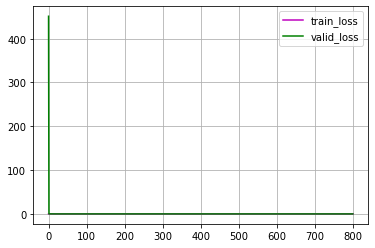

In [62]:
MAPE, MAE, RMSE, load_pred, load_true = run_model_retraining()
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

In [16]:
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

MAPE:0.04765944941346158, MAE:608.9753316715028, RMSE:893.4937634218201


## figure plot

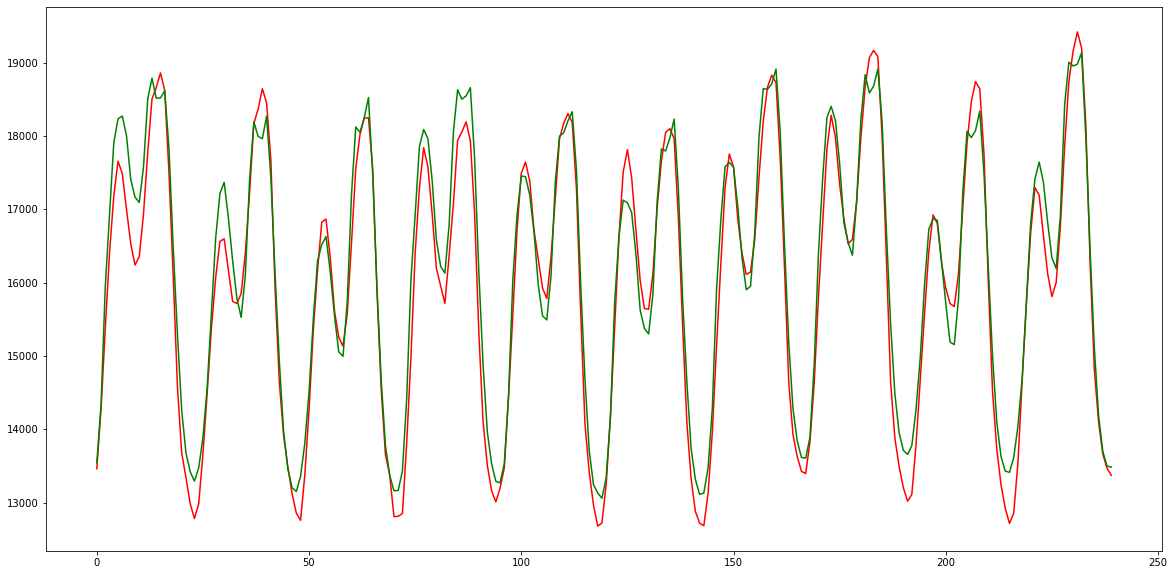

In [17]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, 24)
load_true = load_true.reshape(-1, 24)
plt.plot(load_pred[:240, 0], 'r')
plt.plot(load_true[:240, 0], 'g')